In [94]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from itertools import groupby
from operator import itemgetter
import parallel_plume_sim as pps
import multiprocessing
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from figurefirst import FigureLayout,mpl_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
puff_data_filename = '~/An/data/Oct29Plumes/puff_data_20241029_101718.pickle'

# how many seconds to include per chunk?
max_time = 10

# maximum distance in x and y to consider puffs before ignoring them?
min_x = -5
max_x = 50

min_y = -25
max_y = 25

pps.read_puff_data.split_puff_data_into_smaller_dataframes_and_cull_old_puffs(puff_data_filename, 
                                                                              max_time, 
                                                                              min_x, max_x, 
                                                                              min_y, max_y)

Directory /home/gorilla/An/data/Oct29Plumes/puff_data_20241029_101718 exists, contains 26 files.


Removed all files in:  /home/gorilla/An/data/Oct29Plumes/puff_data_20241029_101718


In [52]:
# This should match your directory name from above -- you need to change this
dirname = '/home/gorilla/An/data/Oct29Plumes/puff_data_20241029_101718/'
# Class for reading puff data
puff_reader = pps.read_puff_data.PuffReader(dirname)

### Generate Trajectories and Collect Odor Encounters

In [53]:
def process_position(position):
    time, x, y = position
    concentration, wind_x, wind_y = puff_reader.get_odor_concentration_at_t_and_position(time, x, y)
    return concentration, wind_x, wind_y

def scale_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (((data - min_val) / (max_val - min_val)) * 10)

def scale_trajectory_to_plume_limits(trajectory_df, x_min=0, x_max=100, y_min=-40, y_max=40):
    df_scaled = trajectory_df.copy()
    
    # Get current limits
    x_orig = df_scaled.distance_along_streakline.values
    y_orig = df_scaled.nearest_from_streakline.values
    
    x_orig_min, x_orig_max = np.min(x_orig), np.max(x_orig)
    y_orig_min, y_orig_max = np.min(y_orig), np.max(y_orig)
    
    # Scale x values to new range
    df_scaled['distance_along_streakline'] = (x_orig - x_orig_min) / (x_orig_max - x_orig_min) * (x_max - x_min) + x_min
    
    # Scale y values to new range
    df_scaled['nearest_from_streakline'] = (y_orig - y_orig_min) / (y_orig_max - y_orig_min) * (y_max - y_min) + y_min
    
    return df_scaled

In [65]:
def process_and_save_existing_trajectory(foldername, dfres):
    # Extract x and y from dfres
    x = dfres.distance_along_streakline.values
    y = dfres.nearest_from_streakline.values
    time = np.linspace(0, 199, len(x))  # Assuming a time array for the length of trajectory
    # time = dfres.time if time is also provided in the file

    # Process the trajectory using multiprocessing
    with multiprocessing.Pool() as pool:
        results = pool.map(process_position, [(time[i], x[i], y[i]) for i in range(len(x))])

    # Extract results for concentration and wind
    c = [result[0] for result in results]
    wx = [result[1] for result in results]
    wy = [result[2] for result in results]

    # Create DataFrame with encounter information
    df_new = pd.DataFrame()
    df_new['time'] = time
    df_new['odor'] = c
    df_new['windx'] = wx
    df_new['windy'] = wy
    df_new['distance_along_streakline'] = x
    df_new['nearest_from_streakline'] = y

    # Save processed data
    processed_filename = f'/home/gorilla/An/data/Oct29Plumes/{foldername}/diag.h5'
    df_new.to_hdf(processed_filename, key='data', mode='w')

### loading plume from pps
dirname = '/home/gorilla/An/data/Oct29Plumes/puff_data_20241029_111917/'
puff_reader = pps.read_puff_data.PuffReader(dirname)
### playing desert trajectory
dfres = pd.read_hdf('/home/gorilla/An/data/WindyMASigned.h5')
dfres['distance_along_streakline']=dfres.distance_along_streakline*dfres.xsign
dfres['nearest_from_streakline']=dfres.nearest_from_streakline*dfres.ysign
dfres = scale_trajectory_to_plume_limits(dfres, x_min=0, x_max=100, y_min=-40, y_max=40)

process_and_save_existing_trajectory('train_raw', dfres)


### Load the dataframe

In [ ]:
def get_index(data,th):
    idx = []
    for i in range(len(data)):
        if (data[i]>=th):
            idx.append(i)
    
    index = []
    for k, g in groupby(enumerate(idx),lambda ix : ix[0] - ix[1]):
        index.append((list((map(itemgetter(1), g)))))
    return index

dfres = pd.read_hdf('/home/gorilla/An/data/Oct29Plumes/train_raw/diag.h5')
dfres['scaled_odor'] = scale_data(dfres['odor'])

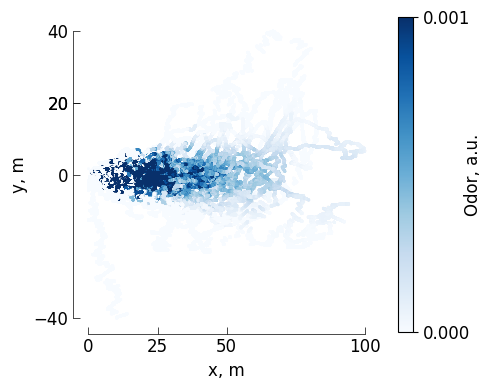

In [104]:
f,ax=plt.subplots(1,1,figsize=(5,4))
cax1=ax.scatter(dfres['distance_along_streakline'], dfres['nearest_from_streakline'], c=dfres['scaled_odor'], 
                s=1, cmap='Blues', vmin=0, vmax=0.001)
mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0,25,50,100],
                            yticks=[-40,20,0,20,40],
                            linewidth=0.5)
ax.set_xlabel('x, m')
ax.set_ylabel('y, m')
cb1=plt.colorbar(cax1)
cb1.set_label('Odor, a.u.',labelpad=-5)
cb1.set_ticks([0,0.001])
mpl_functions.set_fontsize(ax, 12)
f.tight_layout()

In [118]:
dfres.scaled_odor.median()

3.739387682673831e-05

In [121]:
index = get_index(dfres.scaled_odor,0.0001)
whiff_initiation_points = [sub[0] for sub in index]
dfres['whiff_flag'] = 0

# Set 1 for the specified indices in the 'whiff_flag' column
dfres.iloc[whiff_initiation_points, dfres.columns.get_loc('whiff_flag')] = 1

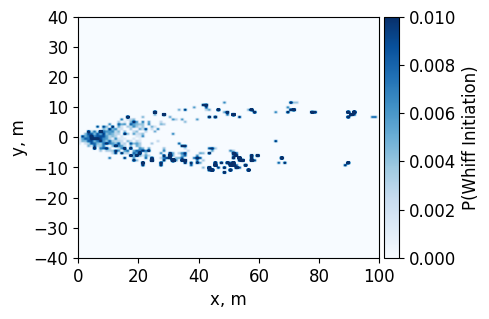

In [122]:
n_bins_x = n_bins_y = 100
heatmap_whiff, xedges, yedges = np.histogram2d(
    dfres['distance_along_streakline'], 
    dfres['nearest_from_streakline'], 
    bins=[n_bins_x, n_bins_y], 
    weights=dfres['whiff_flag']
)

heatmap_total, _, _ = np.histogram2d(
    dfres['distance_along_streakline'], 
    dfres['nearest_from_streakline'], 
    bins=[n_bins_x, n_bins_y]
)

# Calculate empirical probabilities (Equation 1)
with np.errstate(divide='ignore', invalid='ignore'):
    heatmap_prob = np.divide(
        heatmap_whiff, 
        heatmap_total, 
        out=np.zeros_like(heatmap_whiff), 
        where=heatmap_total != 0
    )

f, ax = plt.subplots(1, 1, figsize=(5, 5))
cax = ax.imshow(
    heatmap_prob.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='Blues', vmin=0, vmax=0.01
)

divider = make_axes_locatable(ax)
cbar = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax, cax=cbar, label='P(Whiff Initiation)')
ax.set_xlabel('x, m')
ax.set_ylabel('y, m')
# ax.set_title('P(Whiff Initiation)')
mpl_functions.set_fontsize(f,12)
f.tight_layout()

Optimal Parameters:
A = 0.016667849621691485
x0 = 0.0
y0 = 0.0
sigma_y = 0.3654828623245816
dy = 0.6007299358578605
dist x = 1.0


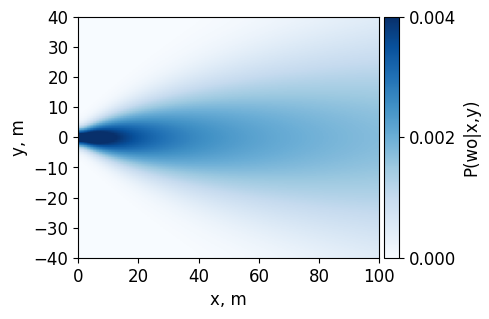

In [137]:

# Set up grid for analysis
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
X_centers, Y_centers = np.meshgrid(x_centers, y_centers, indexing='ij')

# Prepare data for optimization
X_flat = X_centers.flatten()
Y_flat = Y_centers.flatten()
k_obs = heatmap_whiff.flatten()
n_obs = heatmap_total.flatten()

# Filter valid bins
valid_bins = n_obs > 0
X_flat = X_flat[valid_bins]
Y_flat = Y_flat[valid_bins]
k_obs = k_obs[valid_bins]
n_obs = n_obs[valid_bins]


def directional_gaussian_plume(x, y, A, x0, y0, base_sigma_y, distance_scale_factor_y, decay_factor_x):
    distance_x = x - x0
    distance_y = y - y0
    # distance_from_source = np.sqrt((x - x0)**2 + (y - y0)**2)
    # Simple sigma_y growth
    sigma_y = base_sigma_y + distance_scale_factor_y * np.power(np.abs(distance_x), 0.8)  # stronger growth with distance
    
    # Basic Gaussian terms
    gaussian_y = np.exp(-(distance_y**2) / (2 * sigma_y**2))
    # decay_term_x = np.exp(-decay_factor_x * distance_x)
    decay_term_x = 1 / (1 + decay_factor_x * np.power(distance_x, 0.5))  # Power law decay
    

    
    return A * gaussian_y * decay_term_x

bounds = [
    (0, 1),  # A (amplitude)
    (0, 0),          # x0 fixed
    (0, 0),          # y0 fixed
    (0.2, 5.0),      # base_sigma_y
    (0.55, 2.0),     # distance_scale_factor_y - for gradual spread
    (0.02, 1)        # decay_factor_x
]

# initial_params = [0.01, 0.0, 0.0, 0.1, 1.0, 0.02]
initial_params = [0.5, 0.0, 0.0, 1.0, 0.3, 0.005]

# Negative log-likelihood function
def negative_log_likelihood(params, x, y, k, n):
    A, x0, y0, base_sigma_y, distance_scale_factor_y, decay_factor_x = params
    p = directional_gaussian_plume(x, y, A, x0, y0, base_sigma_y, distance_scale_factor_y, decay_factor_x)
    epsilon = 1e-10
    p = np.clip(p, epsilon, 1 - epsilon)
    ll = k * np.log(p) + (n - k) * np.log(1 - p)
    return -np.sum(ll)

# Perform optimization
result = minimize(
    negative_log_likelihood,
    initial_params,
    args=(X_flat, Y_flat, k_obs, n_obs),
    bounds=bounds,
    method='L-BFGS-B'
)

# Extract optimal parameters
optimal_params = result.x
print("Optimal Parameters:")
print(f"A = {optimal_params[0]}")
print(f"x0 = {optimal_params[1]}")
print(f"y0 = {optimal_params[2]}")
print(f"sigma_y = {optimal_params[3]}")
print(f"dy = {optimal_params[4]}")
print(f"dist x = {optimal_params[5]}")


# Compute fitted probabilities
fitted_p = directional_gaussian_plume(
    X_centers, Y_centers, *optimal_params
)
# After calculating fitted_p
scaling_factor = 1.15  # adjust this value as needed
fitted_p = fitted_p * scaling_factor
fitted_p_heatmap_spatial = fitted_p.reshape((len(x_centers), len(y_centers)))

def smooth_heatmap_adjustment(heatmap, region_mask, adjustment_factor, sigma=1.0):
    # Apply the adjustment to the specified region
    adjusted_heatmap = heatmap.copy()
    adjusted_heatmap[region_mask] *= adjustment_factor
    smoothed_heatmap = gaussian_filter(adjusted_heatmap, sigma=sigma)
    
    return smoothed_heatmap

region_mask = (X_centers > 10) & (X_centers < 15)  # Adjust region between 10m and 15m along the streakline
adjustment_factor = 1  # Reduce probability by 20% in this region
sigma_smoothing = 2  # Narrower smoothing for sharper transitions
smoothed_fitted_p_heatmap = smooth_heatmap_adjustment(
    fitted_p_heatmap_spatial, region_mask, adjustment_factor, sigma=sigma_smoothing
)

# Plot the smoothed adjusted heatmap
f, ax = plt.subplots(1, 1, figsize=(5, 5))
cax = ax.imshow(
    smoothed_fitted_p_heatmap.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='Blues', vmin=0, vmax=0.004
)

divider = make_axes_locatable(ax)
cbar = divider.append_axes("right", size="5%", pad=0.05)
cb1 = plt.colorbar(cax, cax=cbar, label='P(wo|x,y)')
cb1.set_ticks([0,0.002, 0.004])
ax.set_xlabel('x, m')
ax.set_ylabel('y, m')
# ax.set_title('P(Whiff Initiation)')

mpl_functions.set_fontsize(f,12)
f.tight_layout()
